In [37]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
%matplotlib inline


import importlib
from globals import *
import cell
import tissue
import time

importlib.reload(cell)
importlib.reload(tissue)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'tissue' from '/home/gili/weizmann/vertex_model/tissue.py'>

In [38]:
T = tissue.Tissue(cell_radius=cell_radius, num_cols=10, num_rows=10)

Node 0: neuron_boundary  (1.0, 0.0) [ 0.22299574 -0.0977257 ]
Node 1: neuron  (0.5, 0.86603) [0.07227449 0.31586307]
Node 2: neuron_boundary  (-0.5, 0.86603) [0.38720038 0.41694818]
Node 3: neuron_boundary  (-1.0, 0.0) [0.13595544 0.17688047]
Node 4: neuron_boundary  (-0.5, -0.86603) [0.3060095  0.38376122]
Node 5: neuron_boundary  (0.5, -0.86603) [-0.03874188  0.00951243]
Node 6: neuron  (2.5, 0.86603) [-0.20926019  0.1074548 ]
Node 7: neuron  (2.0, 1.73205) [0.23975206 0.21126451]
Node 8: neuron  (1.0, 1.73205) [ 0.2282482  -0.15582929]
Node 9: neuron_boundary  (2.0, -0.0) [0.06505667 0.00640831]
Node 10: neuron_boundary  (4.0, 0.0) [0.05663272 0.35830329]
Node 11: neuron  (3.5, 0.86603) [0.04198373 0.31440498]
Node 12: neuron_boundary  (2.5, -0.86603) [0.01068598 0.37707744]
Node 13: neuron_boundary  (3.5, -0.86603) [-0.16678575  0.23226723]
Node 14: neuron  (5.5, 0.86603) [-0.19311553  0.30737288]
Node 15: neuron  (5.0, 1.73205) [-0.05378667  0.42415425]
Node 16: neuron  (4.0, 1.73

KeyboardInterrupt: 

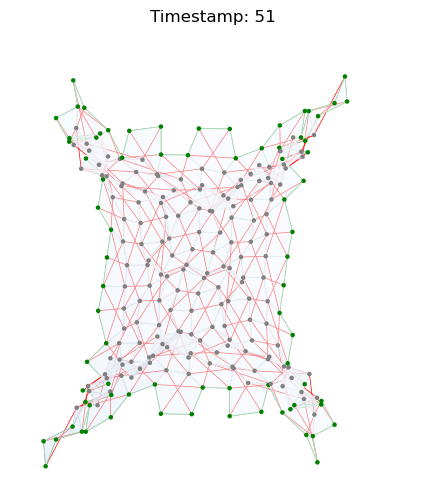

In [39]:
# add some pertubations to check plotting
# original_pos = nx.get_node_attributes(T.graph, 'pos').copy()
# for cell in T.cells:
#     cell.height = np.random.uniform(0.1, 1.0)
#     pts = np.array([original_pos[n] for n in cell.nodes])
#     center = pts.mean(axis=0)
#     for i, n in enumerate(cell.nodes):
#         x, y = original_pos[n]
#         vx, vy = x - center[0], y - center[1]
#         length = np.hypot(vx, vy) or 1.0
#         ux, uy = vx/length, vy/length
#         shift_x = np.random.normal(0, 0.1)
#         shift_y = np.random.normal(0, 0.1)
#         new_pos = (x + ux*shift_x, y + uy*shift_y)
#         T.graph.nodes[n]['pos'] = new_pos


time_limit = 100
total_energy = []
for t in range(1, time_limit):
    # Create a new figure each time
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot tissue
    ax.set_title(f"Timestamp: {t}")
    T.plot_tissue(ax=ax)
    
    # Display the plot
    plt.tight_layout()
    display(fig)
    plt.close(fig)
    
    # For animations in Jupyter notebooks
    clear_output(wait=True)
    time.sleep(0.5)
    
    # Update for next iteration
    # T.compute_all_forces(['spring', 'line_tension'])
    T.compute_all_forces(['spring'])
    T.update_positions(dt=0.5)
    T.update_heights()
    total_energy.append(T.compute_total_energy())

    #dispaly forces on each node
    for i, node in enumerate(T.graph.nodes):
        cell_type = ""
        if T.graph.nodes[node]['neuron']:
            cell_type +="neuron"
        if T.graph.nodes[node]['boundary']:
            if cell_type:
                cell_type += "_"
            cell_type += "boundary"
        print(f"Node {i}: {cell_type}  {node} {T.graph.nodes[node]['force']}")


# Create final figure
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title(f"Timestamp: {time_limit}")
T.plot_tissue(ax=ax)
plt.show()



#graph of total eneergy in time:
plt.plot(total_energy)
plt.xlabel("Time step")
plt.ylabel("Total Energy")
plt.title("Total Energy Over Time")
plt.grid(True)
plt.show()